# Importing Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [2]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/housing-classification-iter-0-2.csv')

In [3]:
houses.isna().sum()

LotArea           0
LotFrontage     259
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
WoodDeckSF        0
ScreenPorch       0
Expensive         0
dtype: int64

In [4]:
houses.describe().round(2)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
count,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,10516.83,70.05,1057.43,2.87,0.61,2.76,1.77,94.24,15.06,0.15
std,9981.26,24.28,438.71,0.82,0.64,40.18,0.75,125.34,55.76,0.36
min,1300.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7553.50,59.00,795.75,2.00,0.00,0.00,1.00,0.00,0.00,0.00
50%,9478.50,69.00,991.50,3.00,1.00,0.00,2.00,0.00,0.00,0.00
75%,11601.50,80.00,1298.25,3.00,1.00,0.00,2.00,168.00,0.00,0.00
max,215245.00,313.00,6110.00,8.00,3.00,738.00,4.00,857.00,480.00,1.00


In [5]:
houses.sort_values(by='BedroomAbvGr', ascending=False)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
635,10896,60.0,1440,8,0,0,0,0,0,0
570,13101,74.0,1728,6,0,0,2,0,0,0
1350,11643,91.0,1248,6,0,0,4,0,0,0
291,5687,55.0,780,6,0,0,0,0,0,0
144,9100,70.0,1728,6,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1163,12900,60.0,1198,0,0,0,2,120,0,0
53,50271,68.0,1842,0,1,0,3,857,0,1
189,4923,41.0,1593,0,1,0,2,0,224,1
634,6979,64.0,1056,0,0,0,2,264,0,0


# Train-Test Split

In [6]:
X = houses.drop(columns='Expensive')
y = houses['Expensive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

# Handle Missing Values

In [7]:
columns = X_train.columns
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X_train)
X_train_imputed = imp.transform(X_train)
X_test_imputed = imp.transform(X_test)
X_train = pd.DataFrame(X_train_imputed, columns=columns )
X_test = pd.DataFrame(X_test_imputed, columns=columns)

In [8]:
X_train.isna().sum()

LotArea         0
LotFrontage     0
TotalBsmtSF     0
BedroomAbvGr    0
Fireplaces      0
PoolArea        0
GarageCars      0
WoodDeckSF      0
ScreenPorch     0
dtype: int64

In [9]:
X_test.isna().sum()

LotArea         0
LotFrontage     0
TotalBsmtSF     0
BedroomAbvGr    0
Fireplaces      0
PoolArea        0
GarageCars      0
WoodDeckSF      0
ScreenPorch     0
dtype: int64

# Z_Score Model

We assume that the more above average a house is across these features, the more likely it is to be expensive.

In [10]:
def above_average(row):
    z_score = (row-X_train.mean())/X_train.std()
    if z_score.sum() > 5:
        return 1
    else:
        return 0
    
predicted_expensive_train = X_train.apply(above_average, axis = 1) 
# The magic is in the .apply() method. When you use DataFrame.apply(func, axis=1), it applies the function func to each row of the DataFrame.
#For each row, the function computes the Z-Score. The axis=1 argument tells apply to operate row-wise. 
#If you used axis=0, it would operate column-wise.
predicted_expensive_test = X_test.apply(above_average, axis = 1)
#The apply() method creates a new pandas Series that collects each return value from the function for each row it processes. 
#This is then stored in the variable you assign the result to, such as predicted_expensive_train or predicted_expensive_test.

In [11]:
print("Training Accuracy:", accuracy_score(y_train, predicted_expensive_train))
print("Testing Accuracy:", accuracy_score(y_test, predicted_expensive_test))

Training Accuracy: 0.8707191780821918
Testing Accuracy: 0.910958904109589


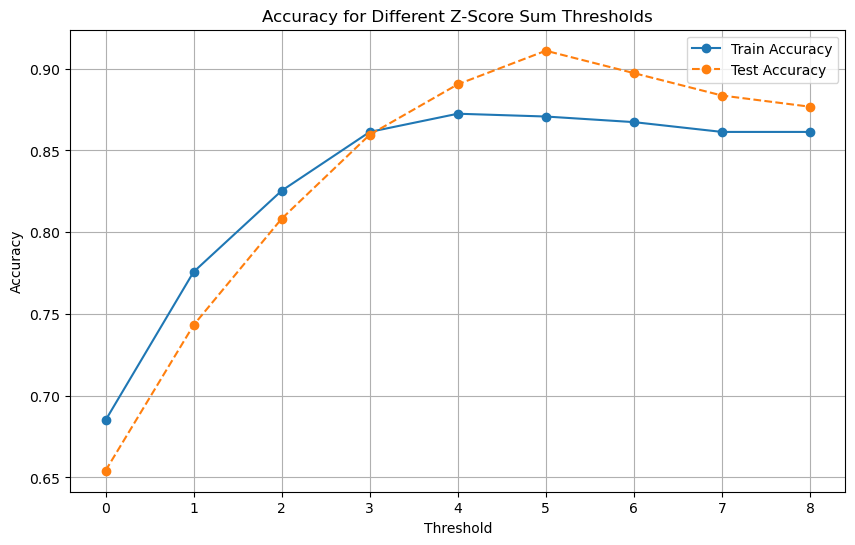

In [12]:
# Intuitive classifier function based on a threshold
def intuitive_classifier(row, threshold):
    z_scores = (row - X_train.mean()) / X_train.std()
    if z_scores.sum() > threshold:
        return 1
    return 0

# Compute accuracies for different thresholds
thresholds = list(range(0, 9))  # Thresholds from 0 to 8
train_accuracies = []
test_accuracies = []

for threshold in thresholds:
    y_pred_train = X_train.apply(intuitive_classifier, axis=1, threshold=threshold)
    y_pred_test = X_test.apply(intuitive_classifier, axis=1, threshold=threshold)
    train_accuracies.append(accuracy_score(y_train, y_pred_train))
    test_accuracies.append(accuracy_score(y_test, y_pred_test))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(thresholds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(thresholds, test_accuracies, marker='o', linestyle='--', label='Test Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Z-Score Sum Thresholds')
plt.legend()
plt.grid(True)
plt.show()


# Coding Rules - Model

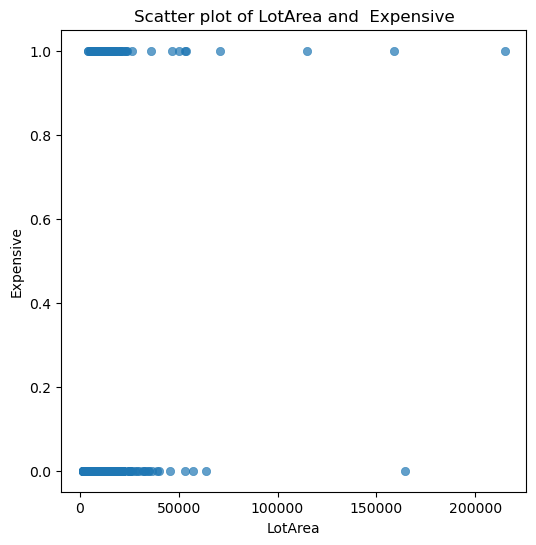

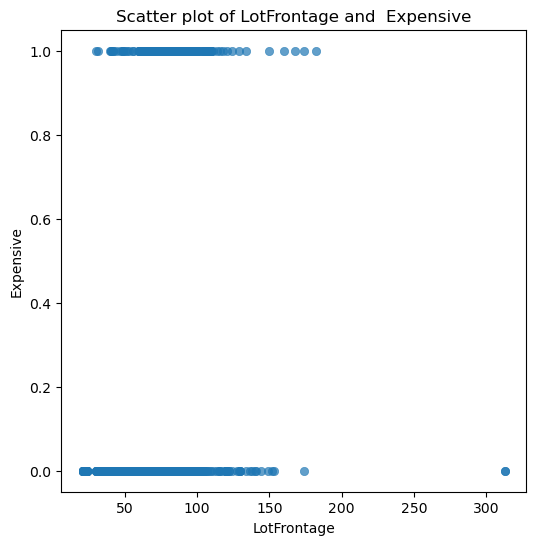

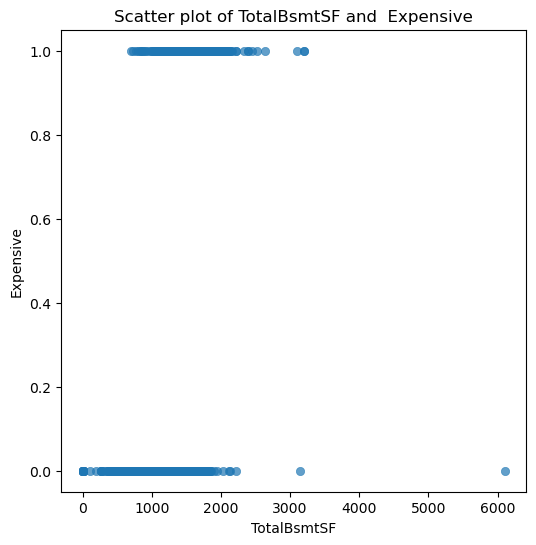

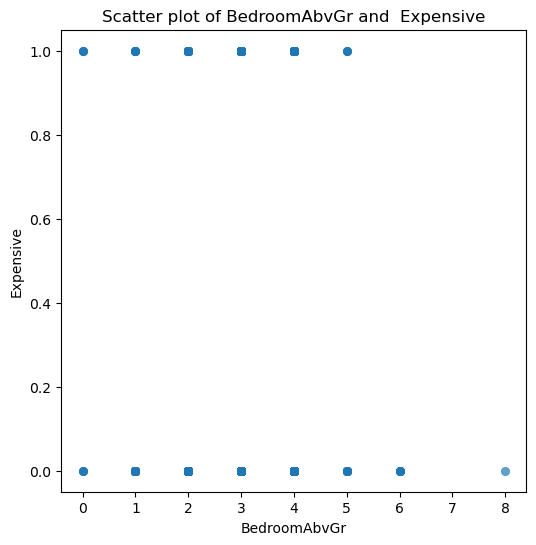

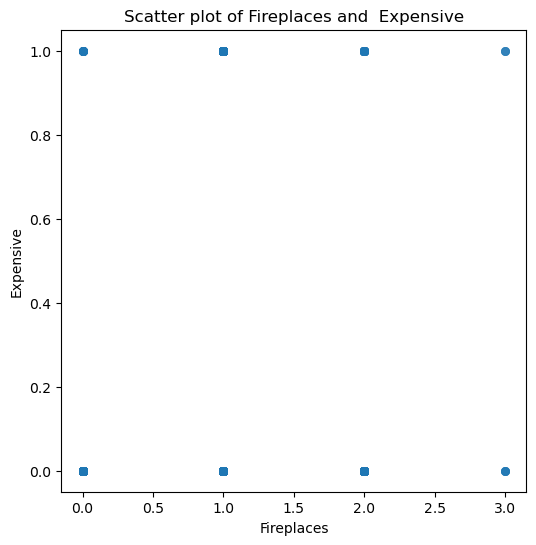

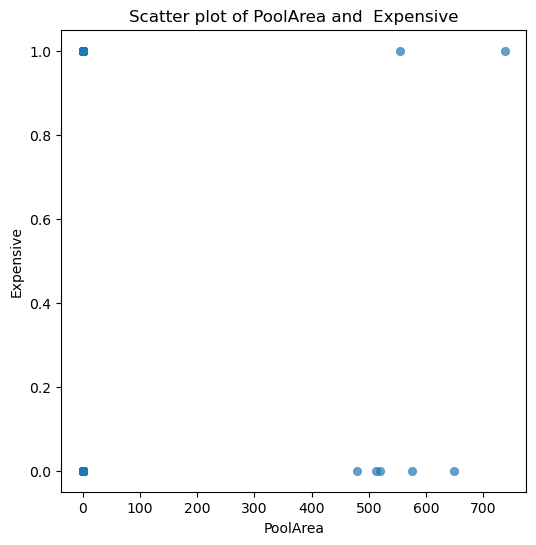

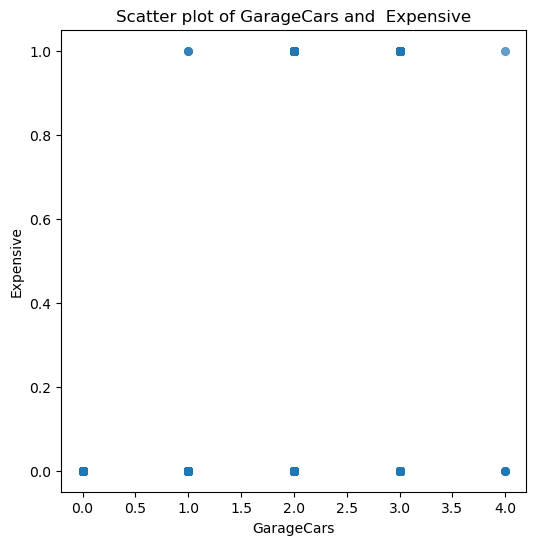

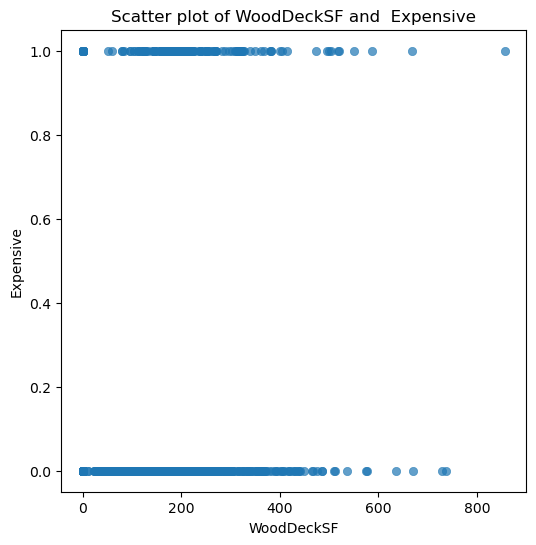

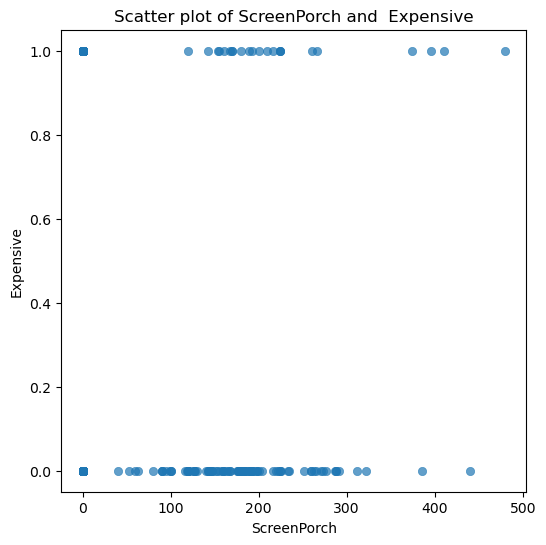

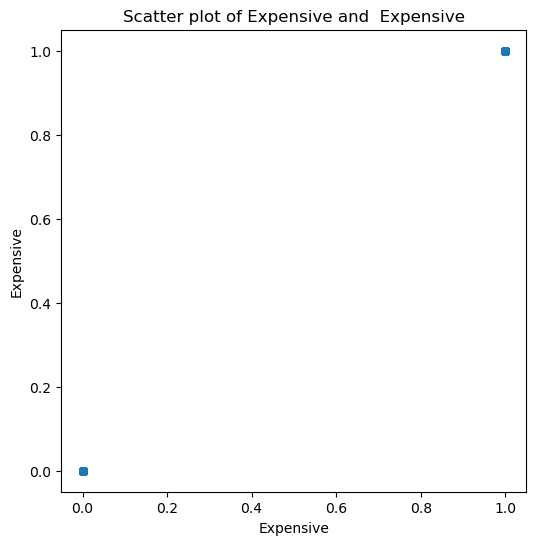

In [13]:
for column in houses.columns:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=houses, x=column, y="Expensive", edgecolor=None, alpha=0.7)

    plt.title(f"Scatter plot of {column} and  Expensive")

    plt.show()

In [14]:
# Initialize intuitive_model with 0 for all indices in X_train
intuitive_model = pd.Series(0, index=X_train.index)

# Rule 1: Houses with GarageCars >= 3 are considered expensive
intuitive_model.loc[X_train['GarageCars'] >= 3] = 1

In [15]:
# Accuracy
train_accuracy = accuracy_score(y_true = y_train, y_pred = intuitive_model)
train_accuracy

0.898972602739726

# Tree Model

In [16]:
my_tree = DecisionTreeClassifier()

# 3. fit the model to the train data
my_tree.fit(X = X_train,
            y = y_train)

DecisionTreeClassifier()

## Evaluate Model on Training Set

In [17]:
y_pred_tree_train = my_tree.predict(X_train)

In [18]:
accuracy_score(y_true = y_train,
               y_pred = y_pred_tree_train
              )

1.0

## Evaluate Model on Test Set

In [19]:
y_pred_tree_test = my_tree.predict(X_test)

In [20]:
accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test
              )

0.8732876712328768

## Plot Model

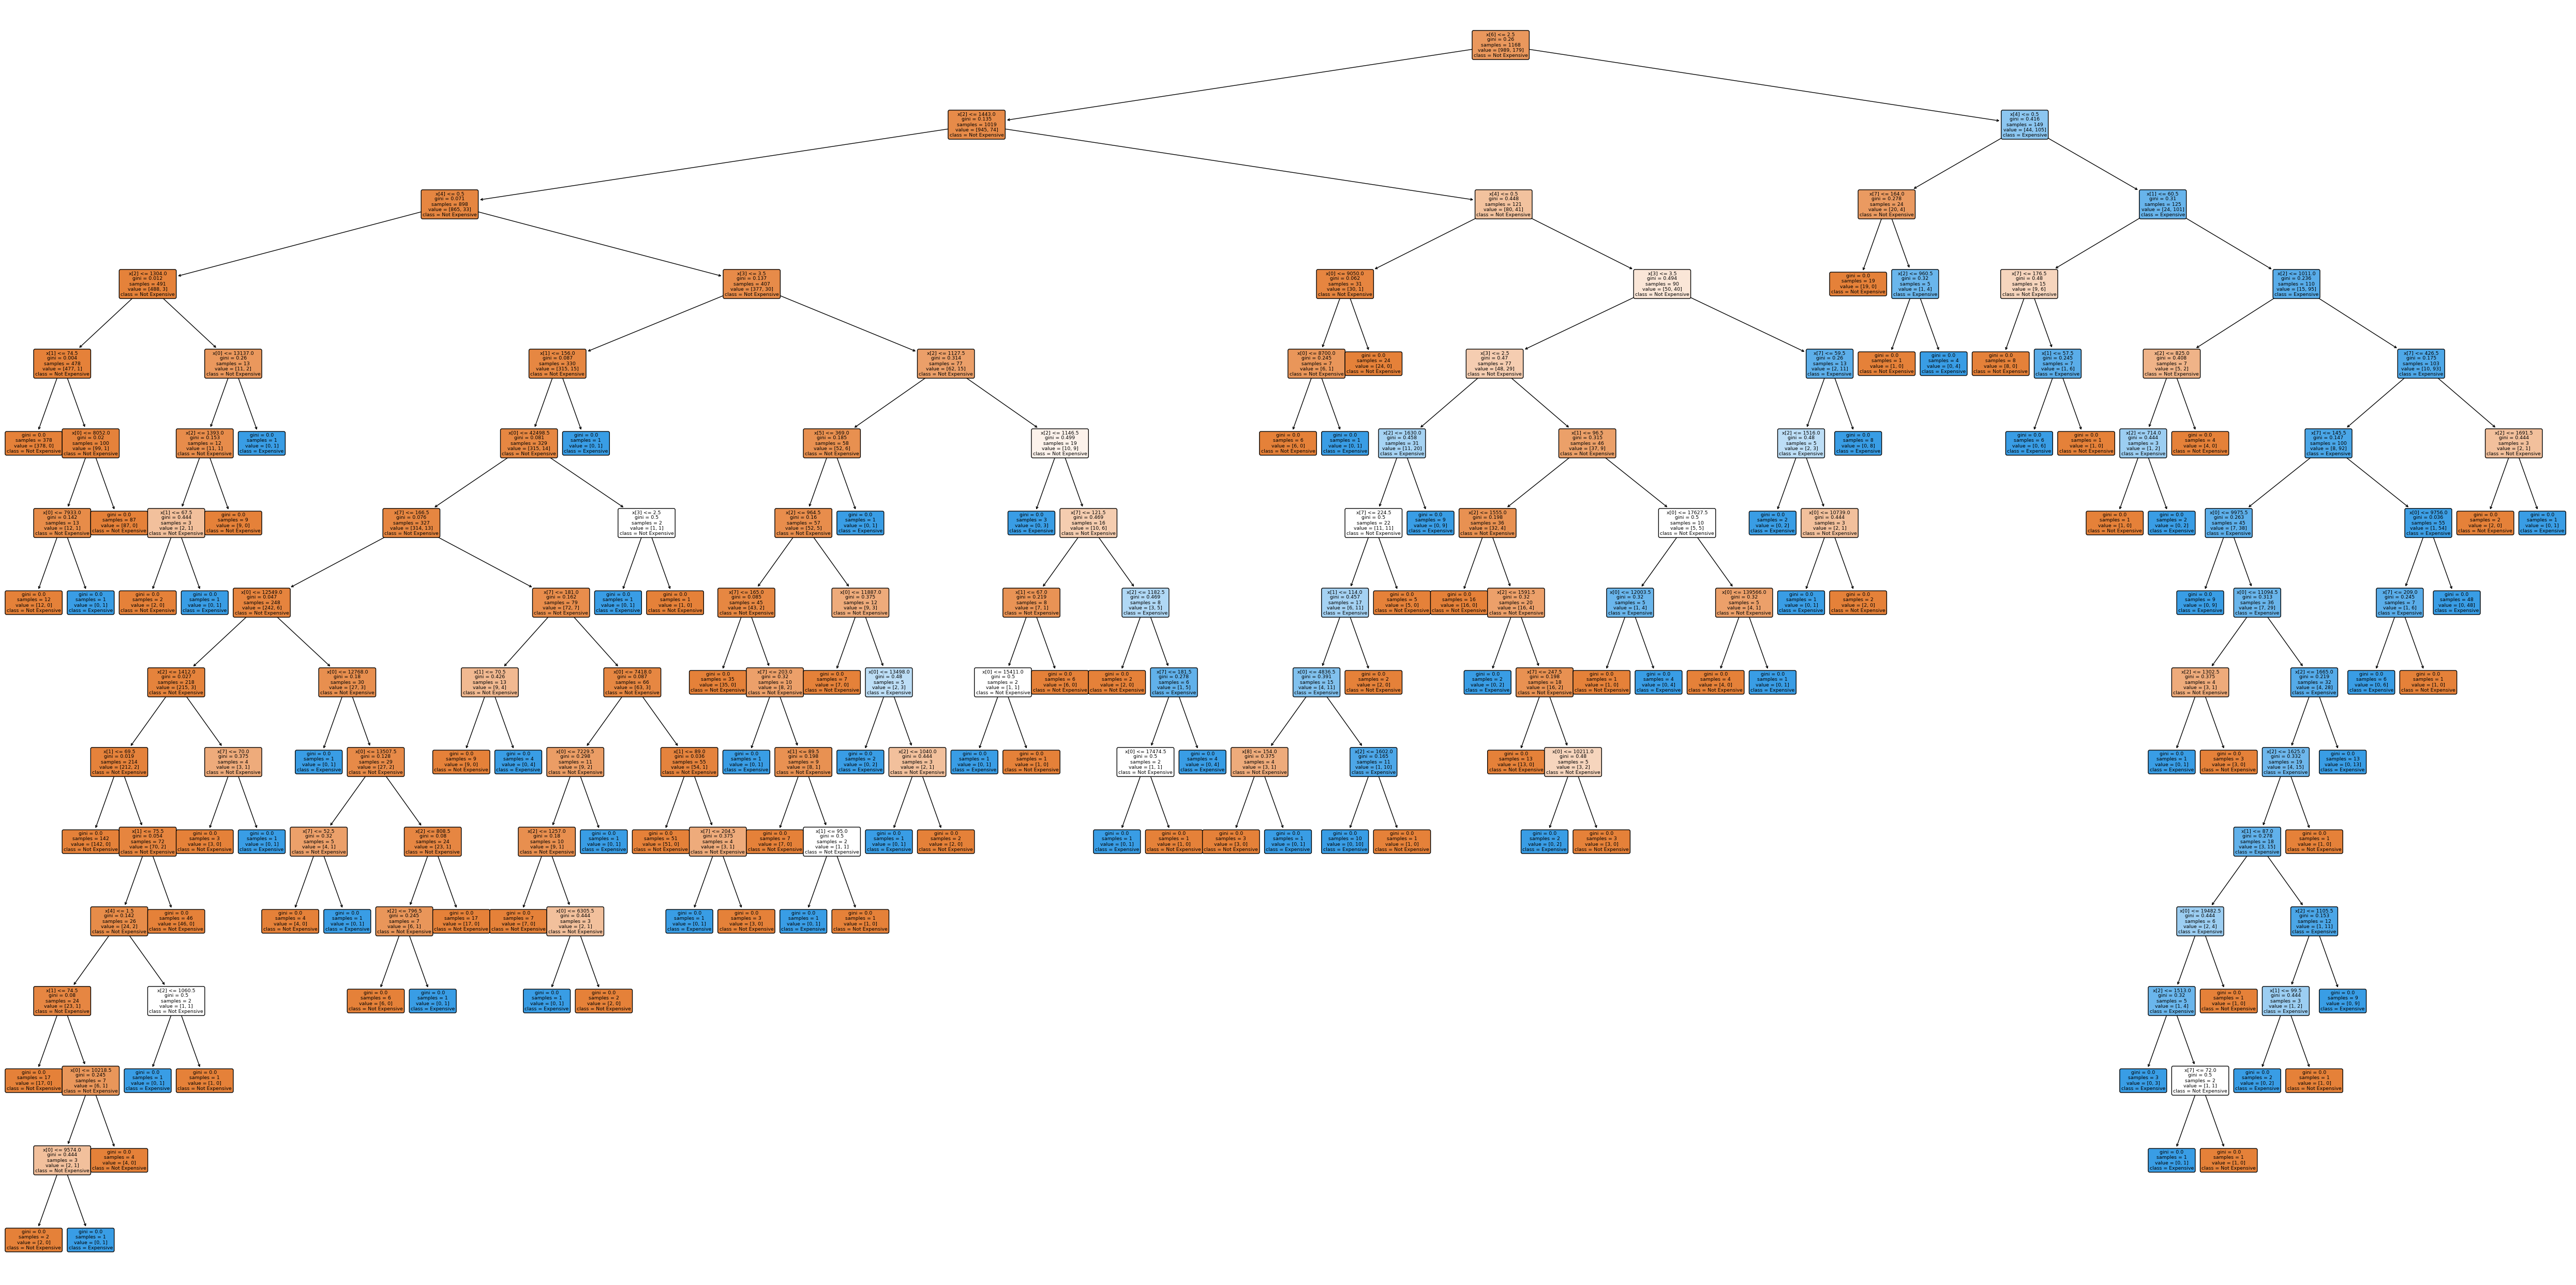

In [21]:
plt.figure(figsize=(64, 32))

plot_tree(
     my_tree,
     filled=True,
     rounded=True,
     class_names=['Not Expensive','Expensive']
     #feature_names=X_train.columns
     );

## Refine Model

In [22]:
my_pruned_tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, random_state=42)

# 3. fit the model to the train data
my_pruned_tree.fit(X = X_train,
            y = y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, random_state=42)

In [23]:
y_pred_tree_train = my_pruned_tree.predict(X_train)
accuracy_score(y_true = y_train,
               y_pred = y_pred_tree_train
              )

0.9306506849315068

In [24]:
y_pred_tree_test = my_pruned_tree.predict(X_test)
accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test
              )

0.934931506849315

### Find optimal Model with some help of visualisations

In [25]:
columns=['accuracy_train', 'accuracy_test', 'max_depth', 'max_leaf']
results = pd.DataFrame(columns=columns)
for i in range(1,12):
    for j in range(1,12):
        my_pruned_tree = DecisionTreeClassifier(max_depth=i, min_samples_leaf=j, random_state=42)
        my_pruned_tree.fit(X = X_train,y = y_train)
        y_pred_tree_train = my_pruned_tree.predict(X_train)
        acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_tree_train)
        y_pred_tree_test = my_pruned_tree.predict(X_test)
        acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_tree_test)
        new_row = pd.DataFrame({
            'accuracy_train': [acc_train],
            'accuracy_test': [acc_test],
            'max_depth': [i],
            'min_samples_leaf': [j]
        })
        results = pd.concat([results, new_row], ignore_index=True)

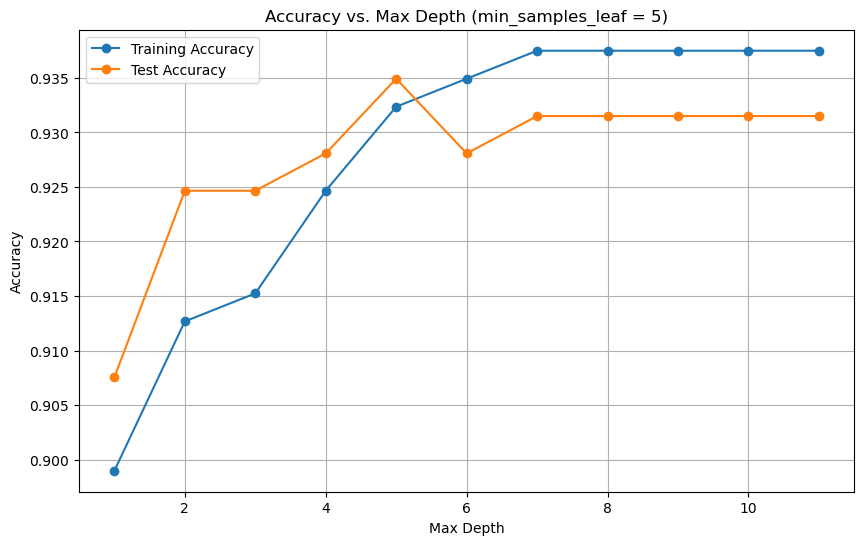

In [26]:
subset = results[results['min_samples_leaf'] == 8]

plt.figure(figsize=(10,6))

# Plotting training and test accuracy
plt.plot(subset['max_depth'], subset['accuracy_train'], '-o', label='Training Accuracy')
plt.plot(subset['max_depth'], subset['accuracy_test'], '-o', label='Test Accuracy')

plt.title('Accuracy vs. Max Depth (min_samples_leaf = 5)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

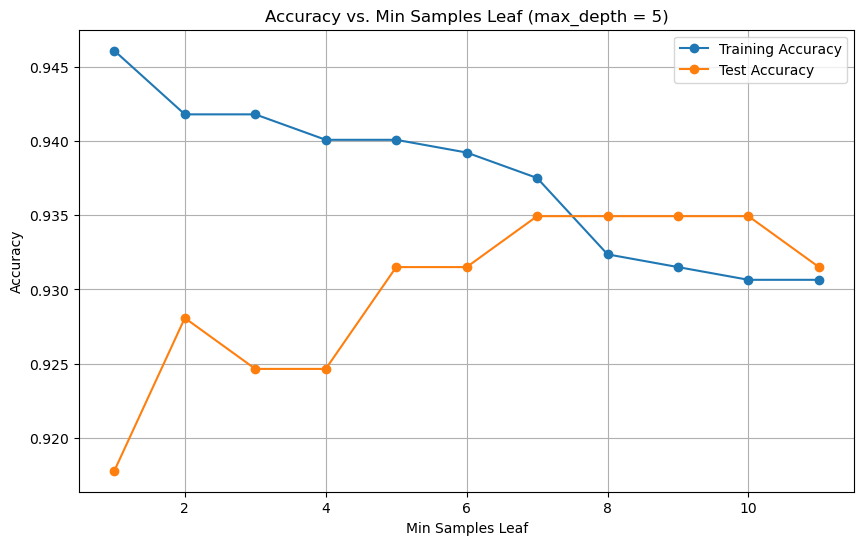

In [27]:
subset = results[results['max_depth'] == 5]

plt.figure(figsize=(10,6))

# Plotting training and test accuracy
plt.plot(subset['min_samples_leaf'], subset['accuracy_train'], '-o', label='Training Accuracy')
plt.plot(subset['min_samples_leaf'], subset['accuracy_test'], '-o', label='Test Accuracy')

plt.title('Accuracy vs. Min Samples Leaf (max_depth = 5)')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Deciding for max_depth = 5 and min_samples_leaf = 8.

In [28]:
my_pruned_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=8, random_state=42)

# 3. fit the model to the train data
my_pruned_tree.fit(X = X_train,
            y = y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=8, random_state=42)

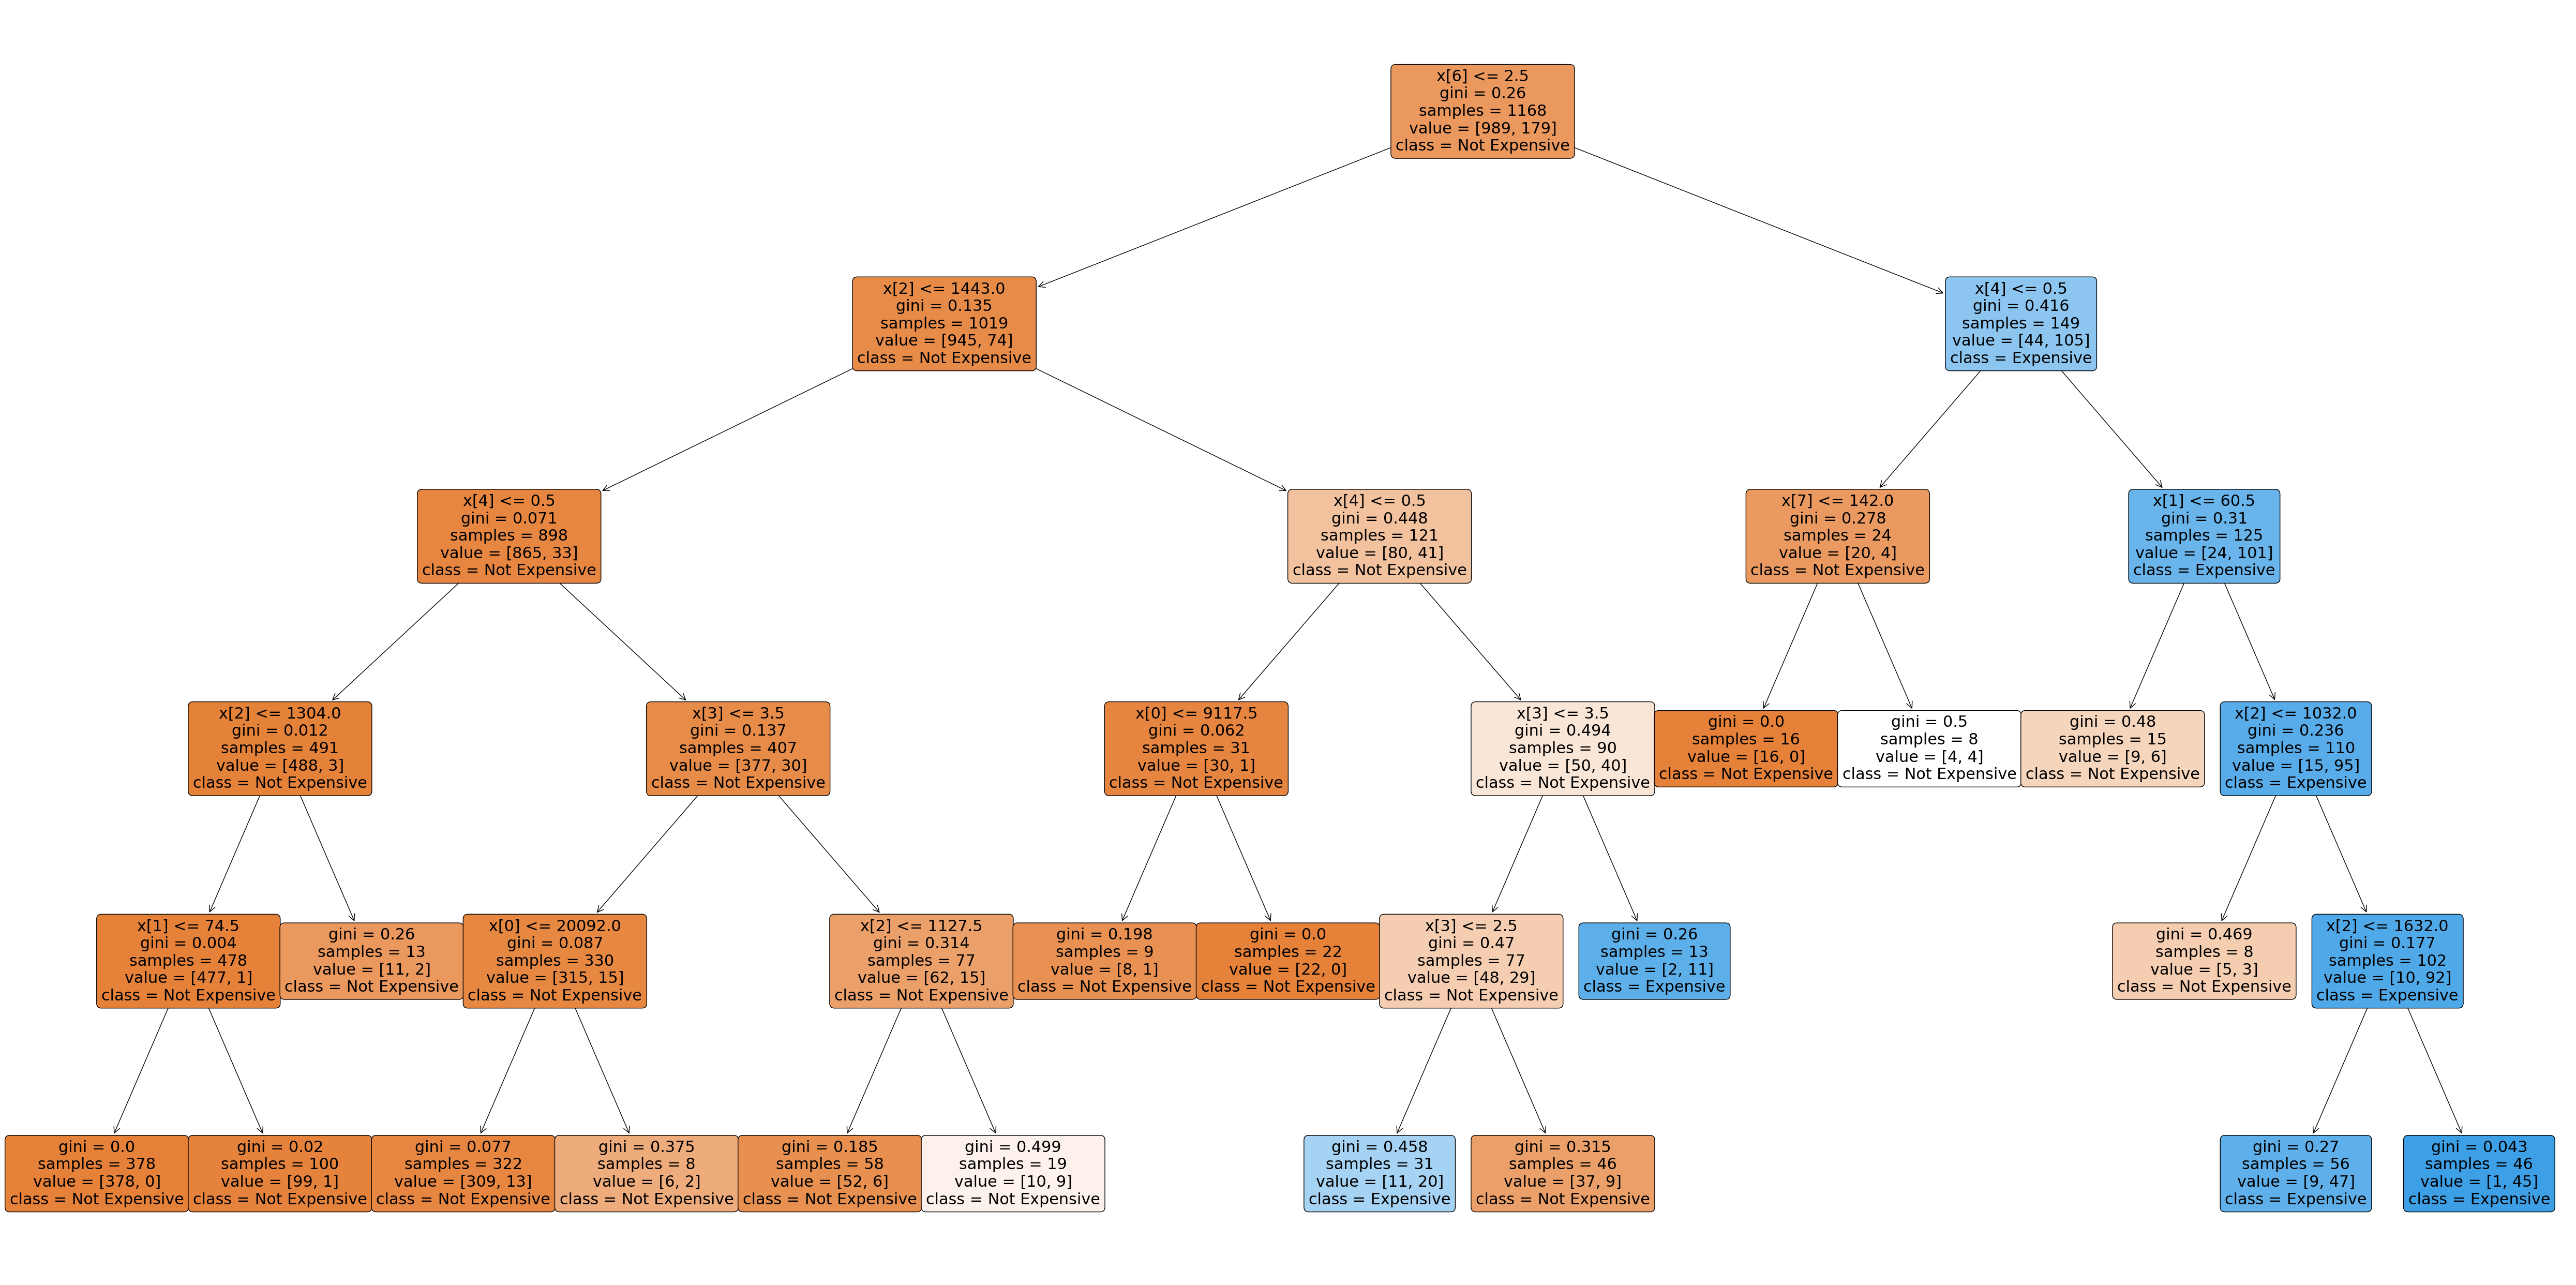

In [29]:
plt.figure(figsize=(64, 32))

plot_tree(
     my_pruned_tree,
     filled=True,
     rounded=True,
     class_names=['Not Expensive','Expensive']
     #feature_names=X_train.columns
     );

### Grid Search

In [46]:
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
}

# 2. Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross validation
    n_jobs=-1,  # Use all CPU cores
    verbose=1  # Print updates during training
)

# 3. Fit the data
grid_search.fit(X_train, y_train)

# 4. Retrieve the best parameters and best estimator
best_params = grid_search.best_params_
best_tree = grid_search.best_estimator_

print("Best parameters found: ", best_params)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# If you want to check the performance on the test set:
test_accuracy = accuracy_score(y_test, best_tree.predict(X_test))
print("Test set accuracy: {:.2f}".format(test_accuracy))

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters found:  {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation accuracy: 0.93
Test set accuracy: 0.93


### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf = RandomForestClassifier(n_estimators=100,  # Number of trees
                            random_state=42,   # Seed for reproducibility
                            n_jobs=-1)         # Use all CPU cores


In [33]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [34]:
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Training accuracy: 0.9991
Test accuracy: 0.9384


In [35]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Set up GridSearchCV for RandomForestClassifier
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross validation
    verbose=1
)

# Fit the data
grid_search_rf.fit(X_train, y_train)

# Retrieve the best parameters and best estimator
best_params_rf = grid_search_rf.best_params_
best_rf = grid_search_rf.best_estimator_

print("Best parameters found for Random Forest: ", best_params_rf)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters found for Random Forest:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [36]:
feature_importances = best_rf.feature_importances_
features = list(X_train.columns)

# Optionally, print sorted feature importances
sorted_indices = feature_importances.argsort()[::-1]
for idx in sorted_indices:
    print(f"{features[idx]}: {feature_importances[idx]:.4f}")

TotalBsmtSF: 0.2968
GarageCars: 0.2247
LotArea: 0.1197
LotFrontage: 0.1056
WoodDeckSF: 0.0998
Fireplaces: 0.0827
BedroomAbvGr: 0.0530
ScreenPorch: 0.0135
PoolArea: 0.0043


#### Refined Random Forest

In [43]:
# Initialize the Random Forest model with the best parameters
rf_tweaked = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=50,
    random_state=42,  # For reproducibility
    n_jobs=-1         # Use all CPU cores
)

# Fit the model to the training data
rf_tweaked.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [44]:
train_preds = rf_tweaked.predict(X_train)
test_preds = rf_tweaked.predict(X_test)

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Training accuracy: 0.9897
Test accuracy: 0.9418


In [45]:
print('This worked!')

This worked!
